## Stting environment

In [1]:
import os, getpass

In [3]:
MISTRAL_token='cFv3TZqVJ1d1yl5EDk1tTCip7flJ3v2u'

In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")
_set_env("HUGGINGFACEHUB_API_TOKEN")
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

# Embeddings and Data store :

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma


embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

### from langchain_cohere import CohereEmbeddings



# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=embeddings,
)

# Create retriever
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.
c:\Users\msi\Documents\rag\venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [4]:
retriever.invoke('prompt engineering')

[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content="Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experiment

# LLMs

In [5]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0.2,
    groq_api_key='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'
)

In [6]:
### Router

from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

# Data model
class RouteQuery(BaseModel):
    """ Route a user query to the most relevant datasource. """

    datasource: Literal["vectorstore", "websearch"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with structured output
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt 
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
                                    
Use the vectorstore for questions on these topics. For all else, use web-search."""

# Test router
print(structured_llm_router.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content="Who will the Bears draft first in the NFL draft?")]))
print(structured_llm_router.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content="What are the types of agent memory?")]))

datasource='websearch'
datasource='vectorstore'


In [7]:
### Retrieval Grader 

from langchain_core.prompts import ChatPromptTemplate

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with structured output
structured_llm_doc_grader = llm.with_structured_output(GradeDocuments)

# Doc grader instructions 
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.

Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# Grader prompt
doc_grader_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}"

# Test
question = "AI agent"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(document=doc_txt, question=question)
print(structured_llm_doc_grader.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)]))

C:\Users\msi\AppData\Local\Temp\ipykernel_9652\2753931103.py:26: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='yes'


In [8]:
structured_llm_doc_grader

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000020353388350>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000020353866590>, model_name='llama-3.1-70b-versatile', temperature=0.2, model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'GradeDocuments', 'description': 'Binary score for relevance check on retrieved documents.', 'parameters': {'properties': {'binary_score': {'description': "Documents are relevant to the question, 'yes' or 'no'", 'type': 'string'}}, 'required': ['binary_score'], 'type': 'object'}}}], 'tool_choice': {'type': 'function', 'function': {'name': 'GradeDocuments'}}}, config={}, config_factories=[])
| PydanticToolsParser(first_tool_only=True, tools=[<class '__main__.GradeDocuments'>])

In [9]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
rag_prompt = """You are an assistant for question-answering tasks. 

Use the following pieces of retrieved context to answer the question. 

If you don't know the answer, just say that you don't know. 

Use three sentences maximum and keep the answer concise.

Question: {question} 

Context: {context} 

Answer:"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Test
question = "The types of agent memory"
docs = retriever.get_relevant_documents(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

The types of agent memory are:

1. Sensory Memory: retains sensory information for a short period (up to a few seconds).
2. Short-Term Memory (STM) or Working Memory: stores information for a short period (20-30 seconds) and has a limited capacity of about 7 items.
3. Long-Term Memory (LTM): stores information for a long time (days to decades) and has an essentially unlimited storage capacity. It has two subtypes: explicit/declarative memory and implicit/procedural memory.


In [13]:
### Hallucination Grader 

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")
    explanation: str = Field(description="Explain the reasoning for the score")

# LLM with function call 
structured_llm_hallucination_grader = llm.with_structured_output(GradeHallucinations)

# Hallucination grader instructions 
hallucination_grader_instructions = """You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = "FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}"

# Test using documents and generation from above 
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=docs_txt, generation=generation)
score = structured_llm_hallucination_grader.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
print(score.binary_score, score.explanation)

yes The student answer is grounded in the facts and does not contain any hallucinated information outside the scope of the facts. The student answer accurately lists the types of agent memory, including Sensory Memory, Short-Term Memory (STM) or Working Memory, and Long-Term Memory (LTM), along with their characteristics. The answer is well-structured and easy to understand, and it demonstrates a clear understanding of the concepts.


In [14]:
score

GradeHallucinations(binary_score='yes', explanation='The student answer is grounded in the facts and does not contain any hallucinated information outside the scope of the facts. The student answer accurately lists the types of agent memory, including Sensory Memory, Short-Term Memory (STM) or Working Memory, and Long-Term Memory (LTM), along with their characteristics. The answer is well-structured and easy to understand, and it demonstrates a clear understanding of the concepts.')

In [15]:
### Answer Grader 

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")
    explanation: str = Field(description="Explain the reasoning for the score")

# LLM with function call 
structured_llm_answer_grader=llm.with_structured_output(GradeAnswer)

# Answer grader instructions 
answer_grader_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is concise and relevant to the QUESTION

(2) Ensure the STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no  means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
answer_grader_prompt = "QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}"

# Test using question and generation from above 
answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation)
score = structured_llm_answer_grader.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
print(score.binary_score, score.explanation)

yes The student answer is concise and relevant to the question about the types of agent memory. The answer provides a clear and detailed list of the three main types of agent memory: Sensory Memory, Short-Term Memory (STM) or Working Memory, and Long-Term Memory (LTM). The answer also explains the characteristics of each type of memory, such as the duration and capacity of each. The answer is well-organized and easy to understand, and it effectively addresses the question.


In [16]:
score

GradeAnswer(binary_score='yes', explanation='The student answer is concise and relevant to the question about the types of agent memory. The answer provides a clear and detailed list of the three main types of agent memory: Sensory Memory, Short-Term Memory (STM) or Working Memory, and Long-Term Memory (LTM). The answer also explains the characteristics of each type of memory, such as the duration and capacity of each. The answer is well-organized and easy to understand, and it effectively addresses the question.')

## WebSearch tool :

In [17]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

## Graph

In [18]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated

class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """
    question : str # User question
    generation : str # LLM generation
    web_search : str # Binary decision to run web search
    max_retries : int # Max number of retries for answer generation 
    answers : int # Number of answers generated
    loop_step: Annotated[int, operator.add] 
    documents : List[str] # List of retrieved documents

In [19]:
from langchain.schema import Document
from langgraph.graph import END

### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step+1}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No" 
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(document=d.page_content, question=question)
        score = structured_llm_doc_grader.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
        grade = score.binary_score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}

### Edges

def route_question(state):
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    source = structured_llm_router.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=state["question"])]) 
    if source.datasource == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source.datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3) # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=format_docs(documents), generation=generation.content)
    score = structured_llm_hallucination_grader.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above 
        answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation.content)
        score = structured_llm_answer_grader.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"  
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"  

## Build Graph :

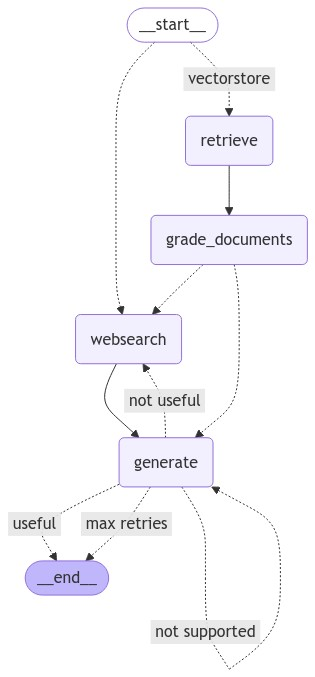

In [20]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
graph_input = {"question": "What are the types of agent memory?", "max_retries": 3}
for event in graph.stream(graph_input, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}, page_content='Fig. 7. Comparison of AD, ED, source policy and RL^2 on environments t

In [54]:
graph_input = {"question": "What is the recent Mistral multi-modal model?", "max_retries": 3}
for event in graph.stream(graph_input, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'What is the recent Mistral multi-modal model?', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
{'question': 'What is the recent Mistral multi-modal model?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={}, page_content='Mistral releases Pixtral 12B, its first multimodal model French AI startup Mistral has released its first model that can process images as well as text. Built on one of Mistral’s text models, Nemo 12B, the new model can answer questions about an arbitrary number of images of an arbitrary size given either URLs or images encoded using base64, the binary-to-text encoding scheme. Similar to other multimodal models such as Anthropic’s Claude family and OpenAI’s GPT-4o, Pixtral 12B should — at least in theory — be able to perform tasks like captioning images and counting the number of objects in a photo. Available via a torrent link on GitHub and AI and machine learning development

In [22]:
event['generation'].content

"The types of agent memory are:\n\n1. Short-term memory: This type of memory is used to store information temporarily and is limited in capacity. \n2. Long-term memory: This type of memory is used to store information over an extended period and is often leveraged by an external vector store and fast retrieval.\n3. Procedural memory: This memory represents the agent's procedures for thinking, acting, decision-making, etc."

In [23]:
graph_input = {"question": "who won the last football world cup ?"}
for event in graph.stream(graph_input, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'who won the last football world cup ?', 'loop_step': 0}
---WEB SEARCH---
{'question': 'who won the last football world cup ?', 'loop_step': 0, 'documents': [Document(metadata={}, page_content='Mbappé, on the other hand, was anonymous until bursting into life by scoring two goals in a 97-second span — one an 80th-minute penalty, the other a volley from just inside the area after a quick exchange of passes — to take the game to extra time at 2-2.\nMessi still had plenty of energy and he was on hand to tap in his second goal in the 108th minute, with a France defender clearing the ball just after it had crossed the line. Messi wins World Cup, Argentina beats France on penalties\nArgentina’s Lionel Messi lifts the trophy after winning the World Cup final soccer match between Argentina and France at the Lusail Stadium in Lusail, Qatar, Sunday, Dec. 18, 2022. France’s Kylian Mbappe runs past Argentina’s Lionel Messi as he 

In [24]:
event['generation'].content

'Argentina won the last football World Cup, beating France on penalties. The final match took place on December 18, 2022, at the Lusail Stadium in Lusail, Qatar. Lionel Messi was awarded the Golden Ball as the best player in the tournament.'

In [25]:
graph_input = {"question": "who won the last football africa cup ?"}
final_event = None
for event in graph.stream(graph_input, stream_mode="values"):
    final_event = event

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


In [26]:
final_event['generation'].content

'The Ivory Coast won the last football Africa Cup, defeating Nigeria 2-1 in the 2024 final hosted in Abidjan.'